In [91]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

Part 1:
1. Load the dataset and preprocess the reviews.

    a. Convert all text to lowercase.

    b. Remove non-alphabetic characters (punctuation).
    
    c. Tokenize the reviews and remove common stopwords.
    
    d. Apply stemming to reduce words to their root form.

2. Split the dataset into training and testing sets (80% training, 20% testing).
3. Use a Naive Bayes classifier to classify the reviews into positive and negative categories.

    a. Implement a Bag-of-Words model using CountVectorizer.
    
    b. Train the Naive Bayes classifier using the training set.

In [92]:
df = pd.read_csv("/content/drive/MyDrive/Concepts-and-Technologies-of-AI/IMDB Dataset.csv")


In [93]:
# Part 1 - Convert labels to numeric (needed for model)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X = df['review']
y = df['sentiment']

In [94]:
# Part 1 - (2) Split dataset 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [95]:
# Part 1 - (3a) Bag-of-Words using CountVectorizer
# Also covers (1a) lowercase, (1b) punctuation removal, (1c) tokenization + stopwords
vectorizer = CountVectorizer(
    lowercase=True,          # (1a)
    stop_words='english',    # (1c)
    max_features=5000
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [96]:
# Part 1 - (3b) Train Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

Part 2:
1. Evaluate the performance of the model using the following metrics:

    a. Accuracy

    b. Precision, Recall, and F1-score
    
    c. Confusion Matrix
    
    d. ROC-AUC Score

In [97]:
# Part 2 - (1) Evaluation metrics
y_pred = model.predict(X_test_vec)
y_prob = model.predict_proba(X_test_vec)[:, 1]# needed for ROC-AUC

In [98]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Accuracy: 0.8446
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      4961
           1       0.85      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix:
 [[4220  741]
 [ 813 4226]]
ROC-AUC Score: 0.9142503829933013


3 Feature Selection Exercise.

3.1 Feature Selection using Wrapper Methods.

Dataset: Breast Cancer Prognostic Dataset

Objective

You are tasked with identifying the most important features in predicting breast cancer prognosis using the
Breast Cancer Prognostic Dataset from the UCI Machine Learning Repository. Apply a wrapper method
(Recursive Feature Elimination) to select the best features and evaluate your model’s performance.

Part 1: Data Loading and Preprocessing
1. Load the Breast Cancer Prognostic Dataset.
2. Dataset is available in Drive.
3. Perform basic exploratory data analysis (EDA) to understand the dataset:


*   Summarize key statistics for each feature.
*   Check for missing values and handle them appropriately.


4. Split the dataset into training (80%) and testing (20%) sets.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [100]:
# Part 1: Load + EDA + Missing Values Handling
CSV_PATH = "/content/drive/MyDrive/Concepts-and-Technologies-of-AI/breast_cancer_prognostic.csv"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

Shape: (198, 34)

Columns: ['outcome', 'time', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'tumor_size', 'lymph_node_status']


In [101]:
# Basic statistics (numeric + non-numeric)
print("\nSummary Statistics:")
display(df.describe(include="all"))


Summary Statistics:


,outcome,time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,tumor_size,lymph_node_status
count,198,198.000000,198.000000,198.00000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,...,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
top,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
freq,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87
mean,NaN,46.732323,17.412323,22.27601,114.856566,970.040909,0.102681,0.142648,0.156243,0.086776,...,140.347778,1404.958586,0.143921,0.365102,0.436685,0.178778,0.323404,0.090828,2.847475,NaN
std,NaN,34.462870,3.161676,4.29829,21.383402,352.149215,0.012522,0.049898,0.070572,0.033877,...,28.892279,586.006972,0.022004,0.163965,0.173625,0.045181,0.075161,0.021172,1.937964,NaN
min,NaN,1.000000,10.950000,10.38000,71.900000,361.600000,0.074970,0.046050,0.023980,0.020310,...,85.100000,508.100000,0.081910,0.051310,0.023980,0.028990,0.156500,0.055040,0.400000,NaN
25%,NaN,14.000000,15.052500,19.41250,98.160000,702.525000,0.093900,0.110200,0.106850,0.063670,...,118.075000,947.275000,0.129325,0.248700,0.322150,0.152650,0.275950,0.076577,1.500000,NaN
50%,NaN,39.500000,17.290000,21.75000,113.700000,929.100000,0.101900,0.131750,0.151350,0.086075,...,136.500000,1295.000000,0.141850,0.351300,0.402350,0.179250,0.310300,0.086890,2.500000,NaN
75%,NaN,72.750000,19.580000,24.65500,129.650000,1193.500000,0.110975,0.172200,0.200500,0.103925,...,159.875000,1694.250000,0.154875,0.423675,0.541050,0.207125,0.358800,0.101375,3.500000,NaN


In [102]:
# Check missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
outcome                    0
time                       0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
tumor_size                 0
lymph_node_stat

In [103]:
# Handle common missing formats (e.g., '?' strings)
df = df.replace("?", np.nan)

In [104]:
# Convert numeric columns safely (everything except outcome)
for col in df.columns:
    if col.lower() != "outcome":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Encode target outcome: R=1, N=0
df["outcome"] = df["outcome"].astype(str).str.strip().str.upper().map({"R": 1, "N": 0})

# If any outcome is still NaN, drop those rows (very rare)
df = df.dropna(subset=["outcome"])

In [105]:
# Fill numeric missing values with median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Final safety check
print("\nAfter Cleaning:")
print("Shape:", df.shape)
print("Outcome counts:\n", df["outcome"].value_counts())


After Cleaning:
Shape: (198, 34)
Outcome counts:
 outcome
0    151
1     47
Name: count, dtype: int64


In [106]:
# Part 1 (continued): Train/Test Split (80/20)
X = df.drop(columns=["outcome"])
y = df["outcome"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nSplit Done:")
print("Train:", X_train.shape, " Test:", X_test.shape)


Split Done:
Train: (158, 33)  Test: (40, 33)


In [107]:
# Standardize features (important for Logistic Regression + RFE)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Part 2: Apply a Wrapper Method
1. Use Recursive Feature Elimination (RFE) with a Logistic Regression model to perform feature selection:


*   Select the top 5 features that contribute the most to predicting the target variable.
*   Visualize the ranking of features.

2. Train the Logistic Regression model using only the selected features.

In [108]:
# Use solver liblinear for small datasets (more stable)
base_model = LogisticRegression(max_iter=5000, solver="liblinear")

rfe_5 = RFE(estimator=base_model, n_features_to_select=5)
rfe_5.fit(X_train_s, y_train)

selected_5 = X.columns[rfe_5.support_]
print("\nTop 5 Features Selected by RFE:")
print(list(selected_5))


Top 5 Features Selected by RFE:
['time', 'smoothness_mean', 'texture_se', 'perimeter_se', 'concave_points_se']


In [109]:
# Create ranking table
ranking_df = pd.DataFrame({
    "Feature": X.columns,
    "Ranking": rfe_5.ranking_
}).sort_values("Ranking")

print("\nFeature Ranking (1 = Best):")
display(ranking_df)


Feature Ranking (1 = Best):


,Feature,Ranking
0,time,1
5,smoothness_mean,1
12,texture_se,1
13,perimeter_se,1
18,concave_points_se,1
6,compactness_mean,2
16,compactness_se,3
17,concavity_se,4
14,area_se,5
21,radius_worst,6


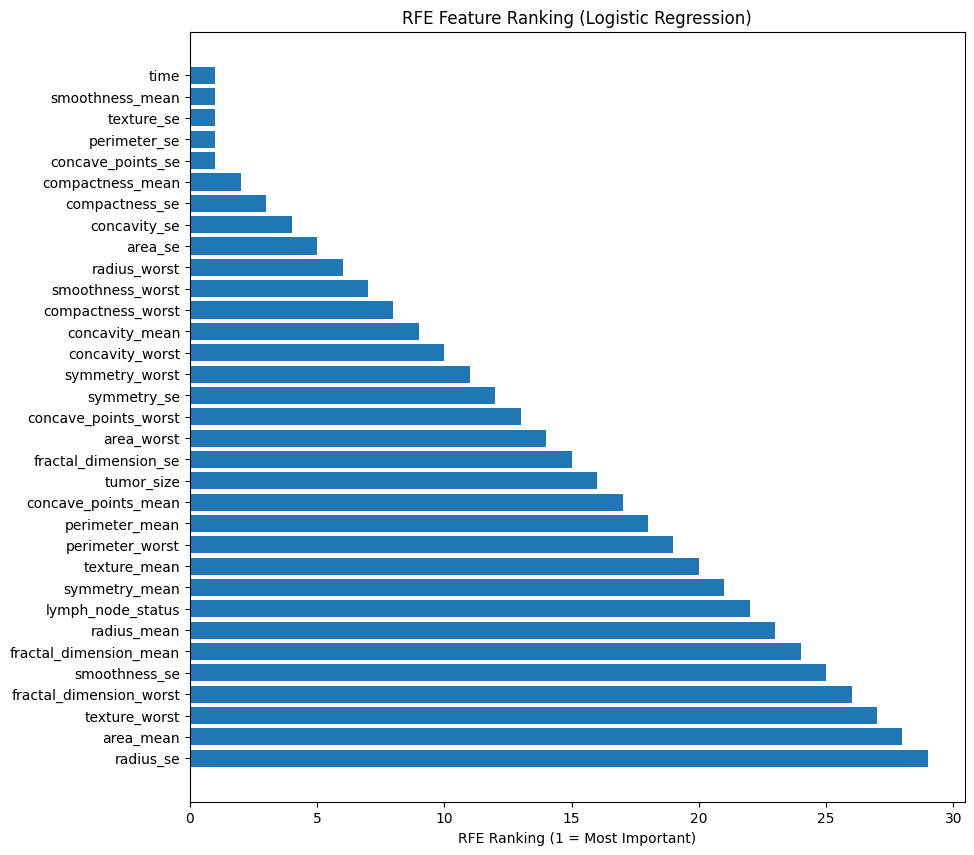

In [110]:
# Visualize ranking
plt.figure(figsize=(10, 10))
plt.barh(ranking_df["Feature"], ranking_df["Ranking"])
plt.xlabel("RFE Ranking (1 = Most Important)")
plt.title("RFE Feature Ranking (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()

Part 3: Model Evaluation
1. Evaluate the model’s performance using the testing set:


*   Metrics to calculate: Accuracy, Precision, Recall, F1-Score, and ROC-AUC.

2. Compare the performance of the model trained on all features versus the model trained on the selected
features.

In [111]:
# Part 3: Model Evaluation (All vs Selected)
def evaluate_model(Xtr, Xte, ytr, yte, name):
    model = LogisticRegression(max_iter=5000, solver="liblinear")
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    prob = model.predict_proba(Xte)[:, 1]

    return {
        "Model": name,
        "Accuracy": accuracy_score(yte, pred),
        "Precision": precision_score(yte, pred, zero_division=0),
        "Recall": recall_score(yte, pred, zero_division=0),
        "F1-Score": f1_score(yte, pred, zero_division=0),
        "ROC-AUC": roc_auc_score(yte, prob)
    }

In [112]:
# All features
res_all = evaluate_model(X_train_s, X_test_s, y_train, y_test, "All Features")

# Only top 5 features
X_train_5 = X_train_s[:, rfe_5.support_]
X_test_5 = X_test_s[:, rfe_5.support_]
res_5 = evaluate_model(X_train_5, X_test_5, y_train, y_test, "Top 5 Features")

comparison_df = pd.DataFrame([res_all, res_5])
print("\nPerformance Comparison (All vs Top 5):")
display(comparison_df)


Performance Comparison (All vs Top 5):


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,All Features,0.850,0.714286,0.555556,0.625000,0.799283
1,Top 5 Features,0.725,0.333333,0.222222,0.266667,0.795699


Part 4: Experiment
1. Experiment with different numbers of selected features (e.g., top 3, top 7).

2. Discuss how feature selection affects model performance.

In [113]:
# Part 4: Experiments with Top 3 and Top 7
exp_results = []

for k in [3, 7]:
    rfe_k = RFE(estimator=base_model, n_features_to_select=k)
    rfe_k.fit(X_train_s, y_train)

    X_train_k = X_train_s[:, rfe_k.support_]
    X_test_k = X_test_s[:, rfe_k.support_]

    exp_results.append(evaluate_model(X_train_k, X_test_k, y_train, y_test, f"Top {k} Features"))

In [114]:
exp_df = pd.DataFrame(exp_results)
print("\nExperiment Results (Top 3 and Top 7):")
display(exp_df)

print("\nDone: EDA + RFE + Evaluation + Experiments completed without errors.")


Experiment Results (Top 3 and Top 7):


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Top 3 Features,0.75,0.333333,0.111111,0.166667,0.777778
1,Top 7 Features,0.75,0.400000,0.222222,0.285714,0.820789



Done: EDA + RFE + Evaluation + Experiments completed without errors.
